In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from amuse.units import units, constants
from amuse.io import read_set_from_file
import argparse
import os
import glob
from amuse.ext.orbital_elements import get_orbital_elements_from_binaries
from amuse.lab import Particles, Particle
from tqdm import tqdm
from scipy.optimize import curve_fit

from plotter import get_com, get_com_vel, plot_inc_ecc


In [4]:
SNAPSHOT_DIR = '/data2/pouw/amuse-project/snapshots-yesdisk/'  # sorry for hard coding my own path...


In [5]:
unsorted_datafiles = glob.glob(SNAPSHOT_DIR + '*.hdf5')
file_numbers = [filename.split('_')[-1].split('.')[0] for filename in unsorted_datafiles]
file_numbers = list(map(int, file_numbers))
times, datafiles = zip(*sorted(zip(file_numbers, unsorted_datafiles)))
times = np.array(times) / 365  # In years
times = times.astype(int)  


In [11]:
median_incs = []
median_eccs = []
plot_time = []
n_bound_list = []

primaries = Particles()
secondaries = Particles()

print(f'Processing {len(datafiles)} snapshots...')
for time, datafile in tqdm(zip(times, datafiles)):
    data = read_set_from_file(datafile)  # Full particle set at single timestep

    primaries.add_particle(data[data.name == 'primary_star'])
    secondaries.add_particle(data[data.name == 'secondary_star'])

    ### USE THIS FOR GETTING ECCENTRICITIES OF THE DISK ###

    # disk = data[data.name == 'disk']
    # stars = data[ np.logical_or(data.name == 'primary_star', data.name == 'secondary_star') ]
    # com = Particle()
    # com.position = get_com(stars)
    # com.velocity = get_com_vel(stars)
    # com.mass = stars[0].mass + stars[1].mass

    # _, _, _, eccs, _, incs, _, _ = get_orbital_elements_from_binaries(com, disk, G=constants.G)

    # bound = eccs < 1
    # bound_eccs = eccs[bound]
    # bound_incs = incs[bound]
    # n_bound = np.sum(bound)

    # median_incs.append(np.median(bound_incs.value_in(units.deg)))
    # median_eccs.append(np.median(bound_eccs))
    plot_time.append(time)
    # n_bound_list.append(n_bound)
    

Processing 8251 snapshots...


8251it [02:02, 67.28it/s]


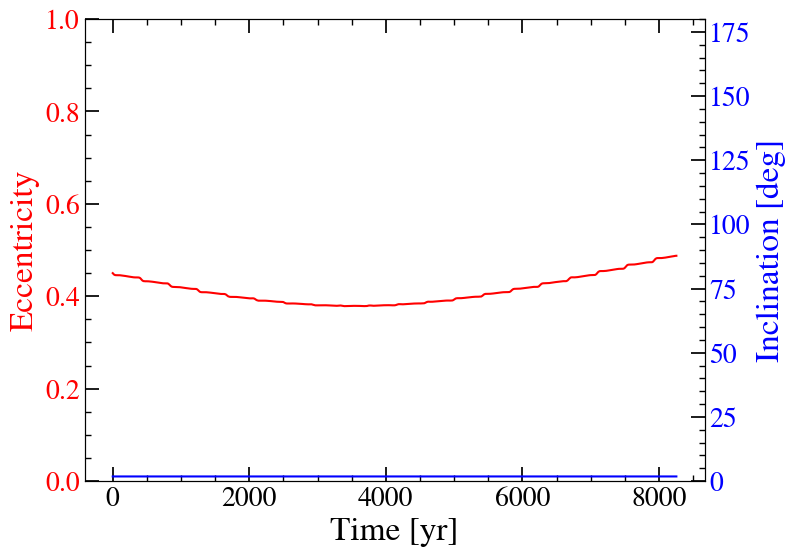

In [12]:
_, _, _, eccs, _, incs, _, _ = get_orbital_elements_from_binaries(primaries, secondaries, G=constants.G)

fig, ax = plt.subplots(figsize=(8,6))
plot_inc_ecc(ax, plot_time | units.yr, incs | units.deg, eccs)
plt.show()


In [ ]:
# np.save('n-bound.npy', np.array(n_bound_list))
# np.save('times-year.npy', np.array(plot_time))
# np.save('bound-incs.npy', np.array(median_incs))
# np.save('bound-eccs.npy', np.array(median_eccs))


In [17]:
n_bound = np.load('n-bound.npy')
times = np.load('times-year.npy')
bound_incs = np.load('bound-incs.npy')
bound_eccs = np.load('bound-eccs.npy')

In [ ]:
def linear(x, a, b):
    return a * x + b

log_time = np.log10(times)
log_n = np.log10(n_bound)

param, pcov = curve_fit(linear, log_time[1800:], log_n[1800:])
print(param, pcov)



[-1.81180202  8.88559238] [[  6.47154106e-06  -2.37304981e-05]
 [ -2.37304981e-05   8.72282726e-05]]


/var/tmp/pouw/ipykernel_2596587/3464256015.py:17: RuntimeWarning: divide by zero encountered in log10
  log_time = np.log10(times)


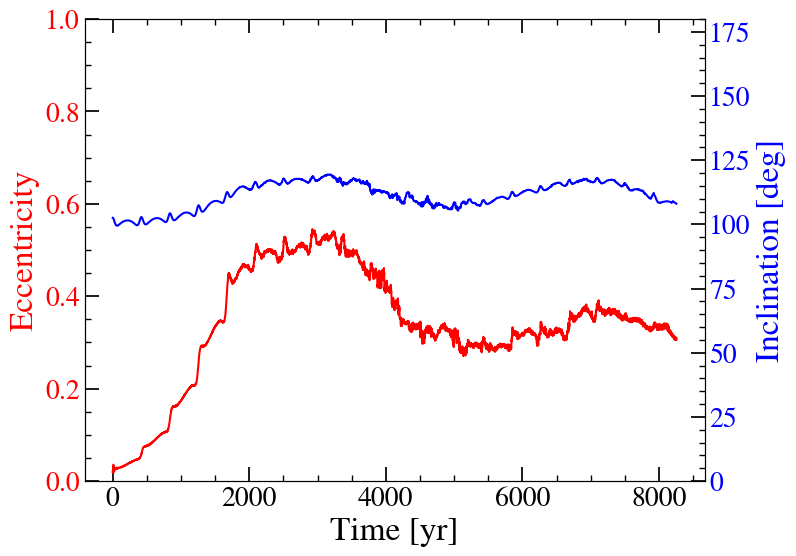

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
plot_inc_ecc(ax, times | units.yr, bound_incs | units.deg, bound_eccs)
plt.show()

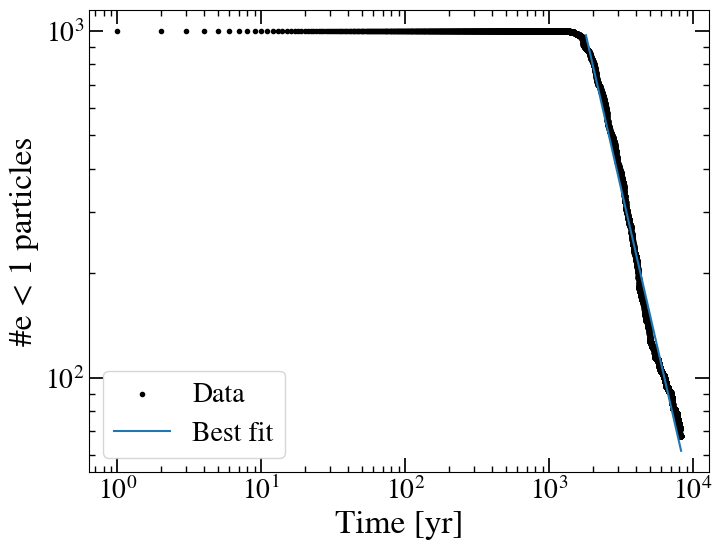

In [21]:
time_range = np.linspace(0, len(plot_time), 1000)

fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(times, n_bound, color='black', marker='.', label='Data')
plt.plot(10**log_time[1800:], 10**linear(log_time[1800:], *param), label='Best fit')
# plt.vlines(t0_opt, 0, 1000, color='red', label='t0')
plt.legend()
plt.loglog()
plt.xlabel('Time [yr]')
plt.ylabel('#e < 1 particles')
plt.show()

